In [58]:
import pandas as pd
pd.set_option('display.max_columns', 200)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer
from category_encoders import CountEncoder, LeaveOneOutEncoder, TargetEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import set_config
set_config(display='diagram')

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import plot_partial_dependence

In [2]:
# Importation des données
df = pd.read_csv('dataset.csv', index_col=0)

# Listes des variables qualitatives
cat_attribs = ['BuildingType', 'PrimaryPropertyType','CouncilDistrictCode',
               'Neighborhood', 'ListOfAllPropertyUseTypes',
               'LargestPropertyUseType', 'PropertyName']

# Liste des variables quantitatives
num_attribs = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
               'ENERGYSTARScore']

# Varible cible
y = 'TotalGHGEmissions'

# Création d'un jeu d'entraînement et d'un jeu de test
train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train = train[cat_attribs + num_attribs]
y_train = train[y].values

# 1. Régression linéaire

In [3]:
model = LinearRegression()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ])

preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA', 'Latitude',
                                  'Longitude', 'ENERGYSTARScore']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'CouncilDistrictCode', 'Neighborhood',
                                  'ListOfAllPropertyUseTypes',
                                  'LargestPropertyUseType', 'PropertyName'])])

In [4]:
# Transformation des données
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.139063,0.314295,1.782311,1.809676,2.328993,2.377868,2.396465
score_time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
test_score,5.0,590.584676,288.756162,225.075164,429.534559,553.148525,790.305424,954.859706
train_score,5.0,1.534266,0.327858,1.228615,1.255623,1.422413,1.837202,1.927478


- __RMSE moyen sur les jeux de validation : 590,58 (± 288.75)__
- Le modèle surajuste considérablement les données d'entraînement : l'écart entre le RMSE sur les données d'entraînement et le RMSE moyen sur les données de validation est énorme. Voyons maintenant si les résultats s'améliore en ajoutant une étape de __sélection de variables__, en sélectionnant les 150 variables les plus pertinentes parmi les 5137 : 

In [5]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=150, score_func=mutual_info_regression))
])

preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(...uter',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('feature_selection',
                 SelectKBest(k=150,
                             score_func=<function mutual_info_regression at 0x0000014E7A03A820>))])

In [6]:
# Transformation des données
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 150)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.121751,0.009694,0.107321,0.120162,0.120770,0.127113,0.133389
score_time,5.0,0.000594,0.000542,0.000000,0.000000,0.000960,0.001004,0.001005
test_score,5.0,103.651130,12.260396,92.892689,94.053486,103.883857,103.943432,123.482187
train_score,5.0,97.226602,3.270717,91.936812,97.093012,97.251651,99.594837,100.256697


- __RMSE moyen sur les jeux de validation : 103,65 (±12,26)__
- En sélectionnant __150 variables__ à l'aide de la classe `SelectKBest()`, il n'y a plus de problème de surajustement. l'écart entre le RMSE obtenu avec les données d'entraînement et de validation s'est nettement réduit.

# 2. Lasso

Voyons si le modèle `Lasso()` nous donne de meilleurs résultats avec le pipeline `preprocessing_pipeline` : 

In [7]:
# Instanciation du modèle Lasso 
model = Lasso()

# Transformation des données
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.280850,0.304383,1.840148,2.157109,2.289117,2.502672,2.615205
score_time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
test_score,5.0,108.375351,10.264733,98.194887,99.032817,110.393198,111.076181,123.179674
train_score,5.0,106.886027,2.752002,102.441357,106.598692,107.061436,109.015399,109.313251


- __RMSE moyen sur les jeux de validation : 108,38 (±10,26)__
- Utilisons à présent le transformateur `preprocessing_and_feature_selection_pipeline`, toujours avec le modèle `Lasso()` :

In [8]:
# Transformation des données
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 150)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.231392,0.019389,0.211980,0.211998,0.235990,0.239993,0.256997
score_time,5.0,0.001001,0.000002,0.000997,0.001001,0.001001,0.001001,0.001004
test_score,5.0,108.841638,10.337190,98.842289,99.179819,111.101184,111.314344,123.770551
train_score,5.0,107.392985,2.759705,102.928994,107.190910,107.481384,109.609284,109.754352


- __RMSE moyen sur les jeux de validation : 108,84 (± 10,34)__
- En rajoutant l'étape de sélection de variables, le RMSE moyen sur les jeux de validation se dégrade légèrement, passant de 108,38 à 108,84. 

# 3. SVR

Voyons si le modèle `SVR()` nous donne de meilleurs résultats avec le pipeline `preprocessing_pipeline` : 

In [9]:
# Instanciation du modèle SVR
model = SVR()

# Transformation des données
X_train_prepared = preprocessing_pipeline.fit_transform(X_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 5137)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.091948,0.087560,0.937536,1.110306,1.122870,1.143014,1.146013
score_time,5.0,0.222725,0.029954,0.171876,0.227101,0.227101,0.237493,0.250055
test_score,5.0,138.062040,17.894452,124.833482,125.576164,131.222094,140.677693,168.000765
train_score,5.0,138.621107,4.722941,130.567189,138.481052,140.475603,141.156091,142.425601


- __RMSE moyen sur les jeux de validation : 138,06 (± 17,89)__
- La moins bonne performance obtenue pour le moment. Utilisons à présent le transformateur `preprocessing_and_feature_selection_pipeline`, toujours avec le modèle `SVR()` :

In [10]:
# Transformation des données
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 150)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.329605,0.194953,1.077502,1.250336,1.265972,1.519293,1.534925
score_time,5.0,0.266892,0.039642,0.199192,0.265611,0.281243,0.293022,0.295393
test_score,5.0,137.646713,17.847015,124.467917,125.194217,130.757392,140.322824,167.491213
train_score,5.0,138.234172,4.762752,130.138238,138.030951,140.082712,140.778503,142.140456


- __RMSE moyen sur les jeux de validation : 137,65 (± 17,85)__
- Le modèle `SVR()` est le modèle donnant les moins bonnes performances prédictives, à la fois sur les données d'entraînement et sur les données de validation, et ce quel que soit le pipeline de transformation utilisé. 

# 4. Random Forest

Voyons si le modèle `RandomForestRegressor()` nous donne de meilleurs résultats avec le pipeline `preprocessing_pipeline` suivant : 

In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('loo', LeaveOneOutEncoder()),
    ])

preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ])

preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA', 'Latitude',
                                  'Longitude', 'ENERGYSTARScore']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('loo',
                                                  LeaveOneOutEncoder())]),
                                 ['BuildingType', 'PrimaryPropertyType',
                                  'CouncilDistrictCode', 'Neighborhood',
                                  'ListOfAllPropertyUseTypes',
                                  'LargestPropertyUseType', 'PropertyName'])])

In [12]:
# Instanciation du modèle
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Transformation des données
X_train_prepared = preprocessing_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 16)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.965030,0.431746,1.204242,2.033788,2.169466,2.182168,2.235489
score_time,5.0,0.038208,0.032269,0.015626,0.015626,0.031261,0.034774,0.093752
test_score,5.0,34.992693,6.823112,29.035317,31.293945,33.266289,34.798086,46.569826
train_score,5.0,12.593165,0.857826,11.764348,11.842705,12.667415,12.818770,13.872587


- __RMSE moyen sur les jeux de validation : 34,99 (± 6,82)__ 
- Les performances du `RandomForestRegressor()` sont bien meilleures que tous nos modèles linéaires. Voyons si les résultats s'améliore en rajoutant une étape de sélection de variables à l'aide de la classe `SelectKBest()`, avec *k=6* : 

In [13]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=6, score_func=mutual_info_regression))
])

preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('loo',
                                                                   LeaveOneOutEncoder())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('feature_selection',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_regression at 0x0000014E7A03A820>))])

In [14]:
# Transformation des données
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 6)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.006736,0.193299,0.689842,0.953683,1.113301,1.128926,1.147930
score_time,5.0,0.029587,0.019751,0.015623,0.015625,0.022437,0.031250,0.063001
test_score,5.0,24.074833,6.945245,14.920494,19.324703,25.865495,27.895512,32.367963
train_score,5.0,8.910026,1.424970,6.690562,8.657400,9.029144,9.668251,10.504774


- __RMSE moyen sur les jeux de validation : 24,07 (± 6,95)__ 
- Les performances se sont améliorées, passant d'un RMSE moyen sur les jeux de validation de 34,99 à 24,07. Nous sommes sur la bonne voie ! 
- Voyons si les performances s'améliore encore en ajoutant une étape __d'expansion polynomiale__ : 

In [15]:
preprocessing_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', SelectKBest(k=6, score_func=mutual_info_regression))
])
preprocessing_and_feature_selection_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'Latitude', 'Longitude',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(...='most_frequent')),
                                                                  ('loo',
                                                                   LeaveOneOutEncoder())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'PropertyName'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('feature_selection',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_regression at 0x0000014E7A03A820>))])

In [16]:
# Transformation des données
X_train_prepared = preprocessing_and_feature_selection_pipeline.fit_transform(X_train, y_train)

# Affichage des dimensions du jeu de données
print("X_train_prepared shape: ", X_train_prepared.shape)

# Evaluation du modèle par validation croisée
stats = cross_validate(model, X_train_prepared, y_train, groups=None,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=2,
                       return_train_score=True)

# Affichage des résultats
stats = pd.DataFrame(stats)
stats['train_score'] = np.sqrt(-stats['train_score'])
stats['test_score'] = np.sqrt(-stats['test_score'])
stats = stats.describe().transpose()
stats

X_train_prepared shape:  (4649, 6)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.944171,0.218065,0.554585,1.025964,1.041543,1.041590,1.057173
score_time,5.0,0.028124,0.006987,0.015625,0.031248,0.031248,0.031250,0.031251
test_score,5.0,19.218642,7.637773,11.450903,14.303250,17.608728,21.669095,31.061232
train_score,5.0,7.288012,0.845339,5.848648,7.346408,7.456108,7.795879,7.993015


- __RMSE moyen sur les jeux de validation : 19,22 (± 7,64)__ 
- Le RMSE moyen sur les données de validation passe de __24,07__ à __19,22__. Belle amélioration ! 
- Nous garderons ce modèle pour régler avec précision ses hyperparamètres.

# Recherche par quadrillage des hyperparamètres

In [17]:
params = {}
params['n_estimators'] = range(90, 110)
params['bootstrap'] = [True, False]

rnd_search = RandomizedSearchCV(estimator=model, param_distributions=params,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, return_train_score=True,
                                n_jobs=-1)

%time rnd_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 3min 13s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'n_estimators': range(90, 110)},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [18]:
cvres = rnd_search.cv_results_

cvres_sample = pd.DataFrame({
    'mean_train_score': np.sqrt(-cvres['mean_train_score']),
    'mean_test_score': np.sqrt(-cvres['mean_test_score']),
    'params': cvres['params']})
cvres_sample = cvres_sample.sort_values('mean_test_score', 
                                        ascending=True).reset_index(drop=True)

cvres_sample.head()

,mean_train_score,mean_test_score,params
0,7.327127,20.396683,"{'n_estimators': 100, 'bootstrap': True}"
1,7.355266,20.406032,"{'n_estimators': 97, 'bootstrap': True}"
2,7.345059,20.416039,"{'n_estimators': 98, 'bootstrap': True}"
3,7.296996,20.423206,"{'n_estimators': 99, 'bootstrap': True}"
4,7.401740,20.438558,"{'n_estimators': 101, 'bootstrap': True}"


In [19]:
cvres_sample.tail()

,mean_train_score,mean_test_score,params
35,2.341515e-13,21.594760,"{'n_estimators': 100, 'bootstrap': False}"
36,2.466895e-13,21.595014,"{'n_estimators': 105, 'bootstrap': False}"
37,2.271188e-13,21.595362,"{'n_estimators': 97, 'bootstrap': False}"
38,2.294141e-13,21.600817,"{'n_estimators': 98, 'bootstrap': False}"
39,2.302567e-13,21.605055,"{'n_estimators': 99, 'bootstrap': False}"


L'absence de bootstap (`bootstrap = False`) semble conduire au __surajustement des données d'entraînement__ (les valeurs de la colonne `mean_train_score` étant très faibles). Faisons une nouvelle recherche par quadrillage __avec bootstrap uniquement :__

In [22]:
params = {}
params['n_estimators'] = range(90, 110)
params['bootstrap'] = [True]

grid_search = GridSearchCV(estimator=model, param_grid=params,
                                cv=5, scoring='neg_mean_squared_error',
                                verbose=2, return_train_score=True,
                                n_jobs=-1)

%time grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 1min 13s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'n_estimators': range(90, 110)},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [24]:
cvres = grid_search.cv_results_

cvres_sample = pd.DataFrame({
    'mean_train_score': np.sqrt(-cvres['mean_train_score']),
    'mean_test_score': np.sqrt(-cvres['mean_test_score']),
    'params': cvres['params']})
cvres_sample = cvres_sample.sort_values('mean_test_score', 
                                        ascending=True).reset_index(drop=True)
cvres_sample.head()

,mean_train_score,mean_test_score,params
0,7.327127,20.396683,"{'bootstrap': True, 'n_estimators': 100}"
1,7.355266,20.406032,"{'bootstrap': True, 'n_estimators': 97}"
2,7.345059,20.416039,"{'bootstrap': True, 'n_estimators': 98}"
3,7.296996,20.423206,"{'bootstrap': True, 'n_estimators': 99}"
4,7.401740,20.438558,"{'bootstrap': True, 'n_estimators': 101}"


La plus petite RMSE moyenne sur les jeux de validation est obtenue avec les paramètres `n_estimators = 100` et `bootstrap = True` 

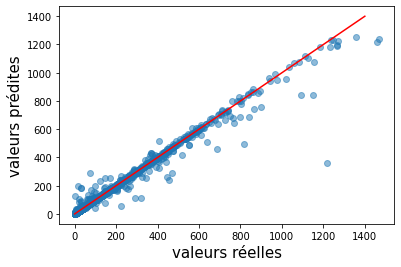

In [25]:
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X_train_prepared, y_train, cv=5)
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot(np.linspace(0, 1_400), np.linspace(0, 1_400), c='red')
plt.xlabel("valeurs réelles", fontsize=15)
plt.ylabel("valeurs prédites", fontsize=15)
plt.show()

# Explication du modèle

Notre pipeline `preprocessing_and_feature_selection_pipeline` transforme nos données en un tableau numPy, ce qui rend difficifile l'identification des variables retenues pour notre modèle. Nous allons ici décomposer chacune des transormations, de manière à conserver un dataframe.

In [26]:
# Instanciation de notre modèles
model = grid_search.best_estimator_

# Pipeline pour les variables quantitatives
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ])

# Pipeline pour les variables qualitatives
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('loo', LeaveOneOutEncoder()),
    ])

# Pipeline complet
preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ])

In [27]:
# Imputation des valeurs manquantes + LeaveOneOutEncoder
X_train_prepared = pd.DataFrame(
    data = preprocessing_pipeline.fit_transform(X_train, y_train),
    columns = num_attribs + cat_attribs
)   
X_train_prepared.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,Latitude,Longitude,ENERGYSTARScore,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,PropertyName
0,2012.0,1.0,2.0,26497.0,57619.0,55000.0,47.648340,-122.331880,68.0,112.864196,38.005627,65.286886,107.744477,53.462287,98.854824,84.241119
1,1962.0,1.0,4.0,0.0,50017.0,50017.0,47.657746,-122.317534,51.0,112.776982,282.464886,64.935070,66.678303,191.200000,272.890345,191.200000
2,1949.0,1.0,18.0,67222.0,326619.0,302922.0,47.617790,-122.345240,81.0,230.272041,225.416294,122.145412,150.419334,123.560303,52.940316,84.241119
3,2008.0,1.0,4.0,0.0,43732.0,43732.0,47.554355,-122.281155,8.0,26.888376,25.068079,69.517574,60.445802,42.918033,53.156536,84.241119
4,1987.0,1.0,3.0,0.0,33176.0,33176.0,47.632450,-122.325290,89.0,112.856338,37.966609,65.255190,107.698314,93.868766,98.831540,84.241119


In [28]:
# Expansion polynomiale 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_prepared = pd.DataFrame(
    data = poly.fit_transform(X_train_prepared),
    columns = poly.get_feature_names(X_train_prepared.columns)
)
X_train_prepared.head()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,Latitude,Longitude,ENERGYSTARScore,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,PropertyName,YearBuilt^2,YearBuilt NumberofBuildings,YearBuilt NumberofFloors,YearBuilt PropertyGFAParking,YearBuilt PropertyGFABuilding(s),YearBuilt LargestPropertyUseTypeGFA,YearBuilt Latitude,YearBuilt Longitude,YearBuilt ENERGYSTARScore,YearBuilt BuildingType,YearBuilt PrimaryPropertyType,YearBuilt CouncilDistrictCode,YearBuilt Neighborhood,YearBuilt ListOfAllPropertyUseTypes,YearBuilt LargestPropertyUseType,YearBuilt PropertyName,NumberofBuildings^2,NumberofBuildings NumberofFloors,NumberofBuildings PropertyGFAParking,NumberofBuildings PropertyGFABuilding(s),NumberofBuildings LargestPropertyUseTypeGFA,NumberofBuildings Latitude,NumberofBuildings Longitude,NumberofBuildings ENERGYSTARScore,NumberofBuildings BuildingType,NumberofBuildings PrimaryPropertyType,NumberofBuildings CouncilDistrictCode,NumberofBuildings Neighborhood,NumberofBuildings ListOfAllPropertyUseTypes,NumberofBuildings LargestPropertyUseType,NumberofBuildings PropertyName,NumberofFloors^2,NumberofFloors PropertyGFAParking,NumberofFloors PropertyGFABuilding(s),NumberofFloors LargestPropertyUseTypeGFA,NumberofFloors Latitude,NumberofFloors Longitude,NumberofFloors ENERGYSTARScore,NumberofFloors BuildingType,NumberofFloors PrimaryPropertyType,NumberofFloors CouncilDistrictCode,NumberofFloors Neighborhood,NumberofFloors ListOfAllPropertyUseTypes,NumberofFloors LargestPropertyUseType,NumberofFloors PropertyName,PropertyGFAParking^2,PropertyGFAParking PropertyGFABuilding(s),PropertyGFAParking LargestPropertyUseTypeGFA,PropertyGFAParking Latitude,PropertyGFAParking Longitude,PropertyGFAParking ENERGYSTARScore,PropertyGFAParking BuildingType,PropertyGFAParking PrimaryPropertyType,PropertyGFAParking CouncilDistrictCode,PropertyGFAParking Neighborhood,PropertyGFAParking ListOfAllPropertyUseTypes,PropertyGFAParking LargestPropertyUseType,PropertyGFAParking PropertyName,PropertyGFABuilding(s)^2,PropertyGFABuilding(s) LargestPropertyUseTypeGFA,PropertyGFABuilding(s) Latitude,PropertyGFABuilding(s) Longitude,PropertyGFABuilding(s) ENERGYSTARScore,PropertyGFABuilding(s) BuildingType,PropertyGFABuilding(s) PrimaryPropertyType,PropertyGFABuilding(s) CouncilDistrictCode,PropertyGFABuilding(s) Neighborhood,PropertyGFABuilding(s) ListOfAllPropertyUseTypes,PropertyGFABuilding(s) LargestPropertyUseType,PropertyGFABuilding(s) PropertyName,LargestPropertyUseTypeGFA^2,LargestPropertyUseTypeGFA Latitude,LargestPropertyUseTypeGFA Longitude,LargestPropertyUseTypeGFA ENERGYSTARScore,LargestPropertyUseTypeGFA BuildingType,LargestPropertyUseTypeGFA PrimaryPropertyType,LargestPropertyUseTypeGFA CouncilDistrictCode,LargestPropertyUseTypeGFA Neighborhood,LargestPropertyUseTypeGFA ListOfAllPropertyUseTypes,LargestPropertyUseTypeGFA LargestPropertyUseType,LargestPropertyUseTypeGFA PropertyName,Latitude^2,Latitude Longitude,Latitude ENERGYSTARScore,Latitude BuildingType,Latitude PrimaryPropertyType,Latitude CouncilDistrictCode,Latitude Neighborhood,Latitude ListOfAllPropertyUseTypes,Latitude LargestPropertyUseType,Latitude PropertyName,Longitude^2,Longitude ENERGYSTARScore,Longitude BuildingType,Longitude PrimaryPropertyType,Longitude CouncilDistrictCode,Longitude Neighborhood,Longitude ListOfAllPropertyUseTypes,Longitude LargestPropertyUseType,Longitude PropertyName,ENERGYSTARScore^2,ENERGYSTARScore BuildingType,ENERGYSTARScore PrimaryPropertyType,ENERGYSTARScore CouncilDistrictCode,ENERGYSTARScore Neighborhood,ENERGYSTARScore ListOfAllPropertyUseTypes,ENERGYSTARScore LargestPropertyUseType,ENERGYSTARScore PropertyName,BuildingType^2,BuildingType PrimaryPropertyType,BuildingType CouncilDistrictCode,BuildingType Neighborhood,BuildingType ListOfAllPropertyUseTypes,BuildingType LargestPropertyUseType,BuildingType PropertyName,PrimaryProp

In [29]:
# Selection de variables
selector = SelectKBest(k=6, score_func=mutual_info_regression)
selector.fit(X_train_prepared, y_train)
cols = selector.get_support(indices=True)
X_train_prepared = X_train_prepared.iloc[:, cols]
X_train_prepared.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,LargestPropertyUseType,Longitude CouncilDistrictCode,CouncilDistrictCode^2
0,112.864196,38.005627,65.286886,98.854824,-7986.667532,4262.377513
1,112.776982,282.464886,64.935070,272.890345,-7942.697648,4216.563298
2,230.272041,225.416294,122.145412,52.940316,-14943.909778,14919.501737
3,26.888376,25.068079,69.517574,53.156536,-8500.689204,4832.693044
4,112.856338,37.966609,65.255190,98.831540,-7982.359994,4258.239772


In [30]:
params = {}
params['n_estimators'] = [100]
params['bootstrap'] = [True]

grid_search = GridSearchCV(estimator=model, param_grid=params,
                          cv=5, scoring='neg_mean_squared_error',
                          verbose=2, return_train_score=True,
                          n_jobs=-1)

grid_search.fit(X_train_prepared, y_train)
cvres = grid_search.cv_results_
cvres_sample = pd.DataFrame({
    'mean_train_score': np.sqrt(-cvres['mean_train_score']),
    'mean_test_score': np.sqrt(-cvres['mean_test_score']),
    'params': cvres['params']})
cvres_sample = cvres_sample.sort_values('mean_test_score', 
                                        ascending=True).reset_index(drop=True)
cvres_sample.head()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,mean_train_score,mean_test_score,params
0,7.327127,20.396683,"{'bootstrap': True, 'n_estimators': 100}"


In [31]:
best_model = grid_search.best_estimator_
feature_importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame(
    sorted(zip(feature_importances, list(X_train_prepared.columns)), reverse=True),
    columns=["score d'importance", 'variable']
    )

# Score d'importance

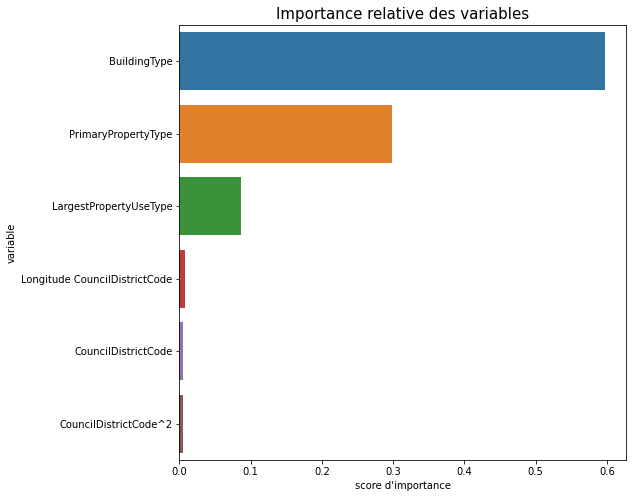

In [78]:
plt.figure(figsize=(8, 8))
sns.barplot(y="variable", x="score d'importance", data=feature_imp_df)
plt.title("Importance relative des variables", fontsize=15)
plt.show()

# Dépendance partielle

In [75]:
features = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
            'LargestPropertyUseType', 'Longitude CouncilDistrictCode',
            'CouncilDistrictCode^2']

est = grid_search
est.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'bootstrap': [True], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

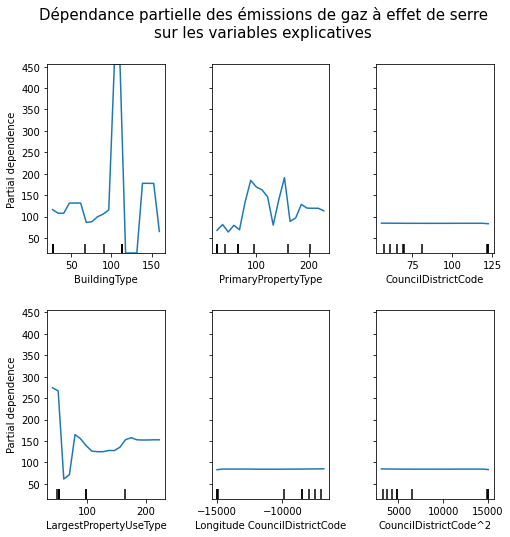

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(est, X_train_prepared, features,
                        n_jobs=3, grid_resolution=20, ax=ax)
fig = plt.gcf()
fig.suptitle('Dépendance partielle des émissions de gaz à effet de serre\n'
             'sur les variables explicatives', fontsize=15)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

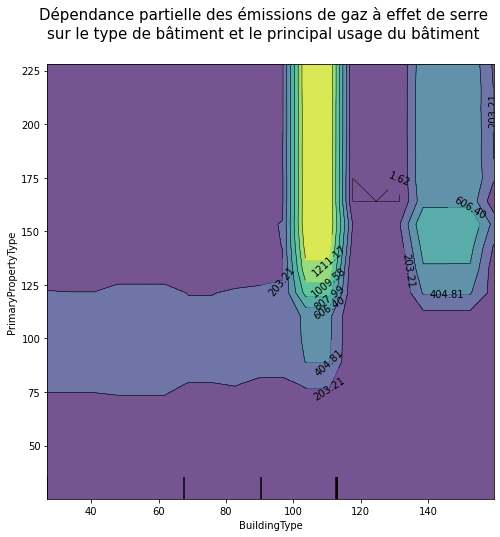

In [77]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_partial_dependence(est, X_train_prepared, [('BuildingType', 'PrimaryPropertyType')],
                        n_jobs=3, grid_resolution=20, ax=ax)

fig = plt.gcf()
fig.suptitle('Dépendance partielle des émissions de gaz à effet de serre\n'
             "sur le type de bâtiment et le principal usage du bâtiment", fontsize=15)
fig.subplots_adjust(wspace=0.4, hspace=0.3)